In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.9 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 50.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 65.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 43.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 31.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 52.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing w

In [ ]:
import cartopy

In [ ]:
from collections import defaultdict
import os
import pickle
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#%tensorflow_version 1.x
import tensorflow as tf

from batchers import batcher, dataset_constants
# from data_analysis.create_folds import create_folds, verify_folds
from utils.geo_plot import setup_ax, plot_locs
from utils.plot import boxplot_df, plot_image_by_band
from utils.general import colordisplay, load_npz


# from utils.general import colordisplay, load_npz
# from utils.plot import boxplot_df, plot_image_by_band

## Create Loc_dict


loc_dict has the format:

{

    (lat, lon): {
        'AlfabIDHM': 0.9516545366327026,
        'IDHL-Sector': 0.8333333333333334,
        'IncomeIDHM': 0.4703847519607078,
        'cluster': 236,
        'municipality': 'APIAI',
        'municipality_year': 'APIAI_2010', #surveyID
        'urban': False
    }, ...
}

## Tentativa 2

In [ ]:
file_path = 'drive/MyDrive/USP/TCC/data/training2/idhm/income/income_image_hists.npz'
npz = load_npz(file_path)

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years)]) == num_examples)

dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask


image_hists: dtype=int64, shape=(9748, 8, 102)
labels: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
years: dtype=int32, shape=(9748,)
nls_center: dtype=float32, shape=(9748,)
nls_mean: dtype=float32, shape=(9748,)


In [ ]:
labels

array([0.6636302 , 0.66822165, 0.6708939 , ..., 0.69654584, 0.69768095,
       0.638     ], dtype=float32)

In [ ]:
def create_loc_dict(loc_dict_path):
    '''
    Args
    - loc_dict_path: str, path to save the loc_dict
    '''
    surveys_df = pd.read_csv('drive/MyDrive/USP/TCC/data/vr_clusters_2.csv', float_precision='high')
    for col in ['lat', 'lon', 'IncomeIDHM']:
        surveys_df[col] = surveys_df[col].astype(np.float32)

    loc_dict = {}
    for (lat, lon) in locs:
        loc = (lat, lon)
        #row = surveys_df[ (surveys_df['lat'] == lat)  & (surveys_df['lon'] == lon) ]
        row = surveys_df.loc[(surveys_df['lat'] == lat) & (surveys_df['lon'] == lon), :]
        assert len(row) == 1
        row = row.iloc[0]

        cy = '{c}_{y}'.format(c=row['group'], y=row['year'])

        assert loc not in loc_dict
        loc_dict[loc] = {
            'cluster': row['cell_id'],
            'group': row['group'],
            'group_year': cy,  
            'IncomeIDHM': row['IncomeIDHM'],
            'year': row['year']
        }

    with open(loc_dict_path, 'wb') as f:
        pickle.dump(loc_dict, f)

In [ ]:
loc_dict_path = 'drive/MyDrive/USP/TCC/data/vr_loc_dict_3.pkl'
loc_dict = create_loc_dict(loc_dict_path)

In [ ]:
loc_dict_path = 'drive/MyDrive/USP/TCC/data/vr_loc_dict_2.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)
loc_dict

{(-26.314129, -51.276913): {'cluster': 2916,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.6636302,
  'year': 2010},
 (-26.252384, -51.277557): {'cluster': 2917,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.66822165,
  'year': 2010},
 (-26.190659, -51.278202): {'cluster': 2918,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.6708939,
  'year': 2010},
 (-26.128948, -51.278847): {'cluster': 2919,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.6729167,
  'year': 2010},
 (-26.067257, -51.27949): {'cluster': 2920,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.6350762,
  'year': 2010},
 (-26.005583, -51.280132): {'cluster': 2921,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.635,
  'year': 2010},
 (-25.943926, -51.280777): {'cluster': 2922,
  'group': 'group10',
  'group_year': 'group10_2010',
  'IncomeIDHM': 0.635,
  'year': 2010},
 (-25.8

## Create Data Splits


In [ ]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

## Create municipality_indices and country_labels

municipality_indices is a dictionary that maps a municipality name to a sorted np.array of its indices
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }


municipality_labels is a np.array that shows which municipality each example belongs to np.array([0, 0, 0, 0, ..., 22, 22, 22])

where countries are indexed by their position in dataset_constants.IDHM_MUNICIPALITIES

In [ ]:
MUNICIPALITIES = np.asarray(dataset_constants.IDHM_MUNICIPALITIES)

vr_df = pd.read_csv('drive/MyDrive/USP/TCC/data/vr_clusters_2.csv', float_precision='high')
locs = vr_df[['lat', 'lon']].values

municipality_indices = defaultdict(list)  # municipality => np.array of indices
municipality_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    municipality = loc_dict[tuple(loc)]['group_year']
    municipality_indices[municipality].append(i)

for i, municipality in enumerate(MUNICIPALITIES):
    municipality_indices[municipality] = np.asarray(municipality_indices[municipality])
    indices = municipality_indices[municipality]
    municipality_labels[indices] = i

In [ ]:
municipality_indices

defaultdict(list,
            {'group1_2010': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                     13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
                     26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
                     39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
                     52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
                     65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
                     78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
                     91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
                    104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
                    117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
                    130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                    143, 144, 14

In [ ]:
municipality_labels

array([ 0,  0,  0, ..., 29, 29, 29], dtype=int32)

OOC SPLITS

In [ ]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']

In [ ]:
# 'A': {
#     'train': np.array([1, 10, 13, ...]),
#     ...
# }
ooc_folds = {
    f: {split: [] for split in SPLITS}
    for f in FOLDS
}

for f in FOLDS:
    surveys_dict = dataset_constants.SURVEY_NAMES[f'IDHM_OOC_{f}']
    for split, countries in surveys_dict.items():
        split_indices = np.sort(np.concatenate([
            municipality_indices[country] for country in countries
        ]))
        ooc_folds[f][split] = split_indices

print('ooc_folds', ooc_folds)
pprint({
    f: {split: len(ooc_folds[f][split])
        for split in SPLITS}
    for f in ooc_folds
})

ooc_folds {'A': {'train': array([ 648,  649,  650, ..., 9745, 9746, 9747]), 'val': array([ 324,  325,  326, ..., 8745, 8746, 8747]), 'test': array([   0,    1,    2, ..., 8421, 8422, 8423])}, 'B': {'train': array([   0,    1,    2, ..., 9745, 9746, 9747]), 'val': array([ 648,  649,  650, ..., 9069, 9070, 9071]), 'test': array([ 324,  325,  326, ..., 8745, 8746, 8747])}, 'C': {'train': array([   0,    1,    2, ..., 9745, 9746, 9747]), 'val': array([ 972,  973,  974, ..., 9393, 9394, 9395]), 'test': array([ 648,  649,  650, ..., 9069, 9070, 9071])}, 'D': {'train': array([   0,    1,    2, ..., 9069, 9070, 9071]), 'val': array([1296, 1297, 1298, ..., 9745, 9746, 9747]), 'test': array([ 972,  973,  974, ..., 9393, 9394, 9395])}, 'E': {'train': array([ 324,  325,  326, ..., 9393, 9394, 9395]), 'val': array([   0,    1,    2, ..., 8421, 8422, 8423]), 'test': array([1296, 1297, 1298, ..., 9745, 9746, 9747])}}
{'A': {'test': 1944, 'train': 5860, 'val': 1944},
 'B': {'test': 1944, 'train': 5860

/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.8/dist-packages/cartopy/io/__ini

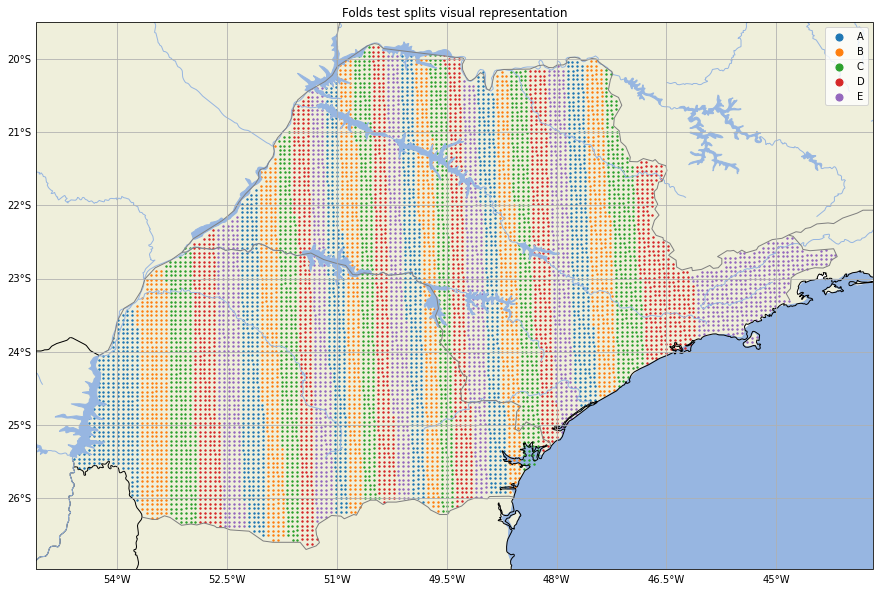

In [ ]:
plot_splits({f: locs[ooc_folds[f]['test']] for f in FOLDS},
            title='Folds test splits visual representation')

## Basic Location Stats

Lat. min: -26.624291, max: -19.839526
Lon. min: -54.586321, max: -44.194287

maximum side_lat: 0.060570
maximum side_lon: 0.067754


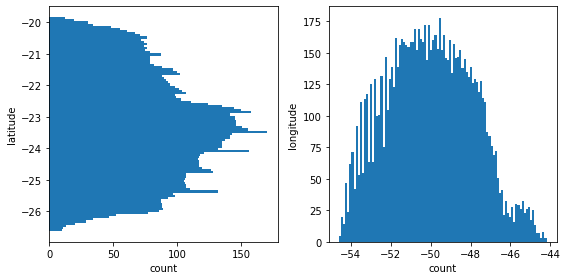

In [ ]:
RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

def get_lon_for_distance(lat, d):
    '''Calculates the degrees longitude for some East-West distance at a given latitude.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees longitude <= returned value

    Args
    - lat: numeric, latitude in degrees
    - d: numeric, distance in km

    Returns
    - lon: float, approximate degrees longitude
    '''
    lat = np.abs(lat) * np.pi / 180.0  # convert to radians
    r = RADIUS_EARTH * np.cos(lat)  # radius at the given lat
    lon = d / r
    lon = lon * 180.0 / np.pi  # convert to degrees
    return lon

def get_lat_for_distance(d):
    '''Calculates the degrees latitude for some North-South distance.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees latitude <= returned value

    Args
    - d: numeric, distance in km

    Returns
    - lat: float, approximate degrees latitude
    '''
    lat = d / RADIUS_EARTH  # in radians
    lat = lat * 180.0 / np.pi  # convert to degrees
    return lat

def print_loc_stats(locs):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon] in degrees
        assumes lat values are + for N, - for S
        assumes lon values are + for E, - for W
    '''
    min_lat, min_lon = np.min(locs, axis=0)
    max_lat, max_lon = np.max(locs, axis=0)
    print(f'Lat. min: {min_lat:.6f}, max: {max_lat:.6f}')
    print(f'Lon. min: {min_lon:.6f}, max: {max_lon:.6f}')
    print()

    # get maximum lat/lon side-lengths for a 224x224 pixel image at 30m / px
    side_distance = 224 * 30 / 1000
    farthest_lat = max(abs(min_lat), abs(max_lat))
    side_lat = get_lat_for_distance(d=side_distance)
    side_lon = get_lon_for_distance(lat=farthest_lat, d=side_distance)
    print(f'maximum side_lat: {side_lat:.6f}')
    print(f'maximum side_lon: {side_lon:.6f}')

def plot_locs_histogram(locs):
    # plot histogram of locations
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])

    # latitudes
    axs[0].hist(locs[:, 0], bins=100, orientation='horizontal')
    axs[0].set(xlabel='count', ylabel='latitude')

    # longitudes
    axs[1].hist(locs[:, 1], bins=100, orientation='vertical')
    axs[1].set(xlabel='count', ylabel='longitude')

    fig.tight_layout()
    plt.show()

locs = vr_df[['lat', 'lon']].values
print_loc_stats(locs)
plot_locs_histogram(locs)

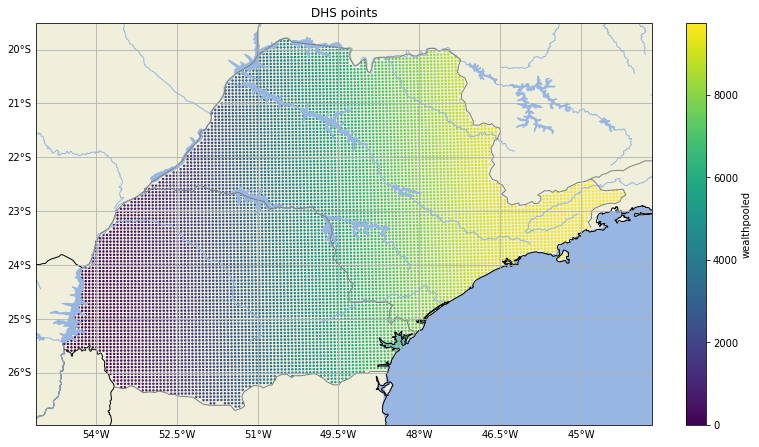

In [ ]:
labels = []
for i in range(len(vr_df)):
  labels.append(i)
  
_ = plot_locs(locs=locs, colors=labels, figsize=[12, 13],
              title='DHS points', cbar_label='wealthpooled')

In [ ]:
def group_by_count(dic, size):
    output, temp, count = [], {}, 0
    for k, v in dic.items():
        for x in v:
          if count == size:
              output.append(temp)
              temp, count = {}, 0
          temp[k] = temp.get(k, []) + [x]
          count += 1
    if temp:
        output.append(temp)
    return output

In [ ]:
output = group_by_count(municipality_indices, 203)
for dic in output:
  print(dic)

{'group1_2010': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202]}
{'group1_2010': [203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

## DATA ANALYSIS BY MUNICIPALITY

In [ ]:
pprint(MUNICIPALITIES, compact=True)

YEARS = sorted(vr_df['year'].unique())
pprint(YEARS, compact=True)

array(['group1_2010', 'group6_2010', 'group11_2010', 'group16_2010',
       'group21_2010', 'group26_2010', 'group2_2010', 'group7_2010',
       'group12_2010', 'group17_2010', 'group22_2010', 'group27_2010',
       'group3_2010', 'group8_2010', 'group13_2010', 'group18_2010',
       'group23_2010', 'group28_2010', 'group4_2010', 'group9_2010',
       'group14_2010', 'group19_2010', 'group24_2010', 'group29_2010',
       'group5_2010', 'group10_2010', 'group15_2010', 'group20_2010',
       'group25_2010', 'group30_2010'], dtype='<U12')
[2010]


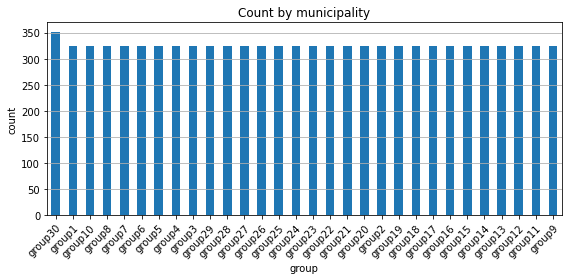

In [ ]:
def plot_municipality_by_size(df):
    counts = df.groupby('group').size()
    counts.sort_values(inplace=True, ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    counts.to_frame().plot(kind='bar', ax=ax, legend=None)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    ax.set_ylabel('count')
    ax.set_title('Count by municipality')
    ax.grid(True, axis='y')
    fig.tight_layout()
    plt.show()

plot_municipality_by_size(vr_df)

In [ ]:
with pd.option_context('display.max_rows', 100):
    counts_series = vr_df.groupby(['group', 'year']).size().rename('count')
    display(counts_series.to_frame())

,,count
group,year,
group1,2010,324
group10,2010,324
group11,2010,324
group12,2010,324
group13,2010,324
group14,2010,324
group15,2010,324
group16,2010,324
group17,2010,324


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


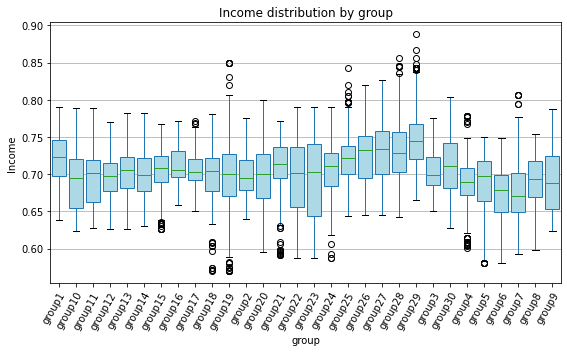

In [ ]:
df = vr_df
#boxplot_df(df, y='IDHL-Sector', by='municipality',
#           figsize=(8, 5), ylabel='Longevity',
#           title='Longevity distribution by municipality',
#          colors=['lightblue' for _ in MUNICIPALITIES])

boxplot_df(df, y='IncomeIDHM', by='group',
           figsize=(8, 5), ylabel='Income',
           title='Income distribution by group',
           colors=['lightblue' for _ in MUNICIPALITIES])

#boxplot_df(df, y='AlfabIDHM', by='municipality',
#           figsize=(8, 5), ylabel='Literacy',
#           title='Literacy distribution by municipality',
#           colors=['lightblue' for _ in MUNICIPALITIES])

# boxplot_df(df, y='wealthpooled', by='year',
#            figsize=(4, 4), ylabel='wealthpooled',
#            title='Wealthpooled distribution by year',
#            colors=['lightblue' for _ in YEARS])

# boxplot_df(df, y='wealthpooled', by=['country', 'year'],
#            figsize=(10, 6), ylabel='wealthpooled',
#            title='Wealthpooled distribution by country_year',
#            colors=COUNTRY_YEAR_COLORS)